In [1]:
from astropy.io import fits
import numpy as np
from astropy.table import QTable,vstack
import astropy.units as u
import astropy.utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import lognorm
from scipy.stats import f
from astropy.timeseries import LombScargle
import time
from astropy.visualization import hist
from scipy.optimize import curve_fit
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.time import Time
from tqdm import tqdm


import functions
#import upsilon

In [3]:
gaia_zr=QTable.read('ztf_gaia_zr.csv')
gaia_zg=QTable.read('ztf_gaia_zg.csv')

In [45]:
t_zr=QTable.read('t_zr_1212.ecsv')
t_zg=QTable.read('t_zg_1212.ecsv')

In [46]:
t_zr['Gaia_count']=0
t_zr['Gmag']=0.0
t_zr['RFG']=0.0
t_zr['Plx']=0.0
t_zr['e_Plx']=0.0
t_zr['var']='N'

t_zg['Gaia_count']=0
t_zg['Gmag']=0.0
t_zg['RFG']=0.0
t_zg['Plx']=0.0
t_zg['e_Plx']=0.0
t_zg['var']='N'

In [38]:
t_zr=QTable.read('t_zr_1212.ecsv')
t_zg=QTable.read('t_zg_1212.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]

var_zr=t_zr[t_zr['sf']<1/(100*len(t_zr))] #99% chance variabe
var_zg=t_zg[t_zg['sf']<1/(100*len(t_zg))] #99% chance variabe

nonvar_zr=t_zr[t_zr['sf']>1/(100*len(t_zr))]
nonvar_zg=t_zg[t_zg['sf']>1/(100*len(t_zg))]

def cut_LNP_SIG(t,period,LNP_SIG):
    #t=t[(t['period']<period[0])|(t['period']>period[1])]
    #t=t[(t['period']<period[2])|(t['period']>period[3])]
    #if len(period)>4:
        #t=t[(t['period']<period[4])|(t['period']>period[5])]
    t=t[t['LNP_SIG']<LNP_SIG]
    return t

t_zr=cut_LNP_SIG(var_zr,_,1/(100*len(t_zr)))
t_zg=cut_LNP_SIG(var_zg,_,1/(100*len(t_zg)))


# cut power ratios
obj_zr=t_zr[t_zr['power']/t_zr['power_c']>=1]
obj_zg=t_zg[t_zg['power']/t_zg['power_c']>=1]


# cut close periods
obj_zr=obj_zr[np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>1e-2]
obj_zg=obj_zg[np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>1e-2]

obj_zr=obj_zr[(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']<0.49)|(np.abs(obj_zr['period']-obj_zr['period_c'])/obj_zr['period_c']>0.91)|(obj_zr['LNP_SIG']<1e-30)]
obj_zg=obj_zg[(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']<0.49)|(np.abs(obj_zg['period']-obj_zg['period_c'])/obj_zg['period_c']>0.91)|(obj_zg['LNP_SIG']<1e-30)]




# restore original table for ploting reasons
t_zr=QTable.read('t_zr_1212.ecsv')
t_zg=QTable.read('t_zg_1212.ecsv')


# choose only OID with highest numobs
mask=np.zeros(len(obj_zr))+1
for i,obj in enumerate(obj_zr):
    copy=t_zr[t_zr['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
        if obj['numobs']<50:
            mask[i]=0
obj_zr=obj_zr[mask==1]


mask=np.zeros(len(obj_zg))+1
for i,obj in enumerate(obj_zg):
    copy=t_zg[t_zg['SourceID']==obj['SourceID']]
    if len(copy)==1:
        if obj['numobs']<50:
            mask[i]=0
    if len(copy)>1:
        if obj['OID']!=copy['OID'][copy['numobs'].argmax()]:
            mask[i]=0
        if obj['numobs']<50:
            mask[i]=0
obj_zg=obj_zg[mask==1]

In [39]:
unobj_zr=var_zr[np.isin(var_zr['SourceID'],obj_zr['SourceID'])==0]
unobj_zg=var_zg[np.isin(var_zg['SourceID'],obj_zg['SourceID'])==0]

In [47]:
for row in t_zr:
    if len(obj_zr[obj_zr['OID']==row['OID']])!=0:
        row['var']='P'
    if len(unobj_zr[unobj_zr['OID']==row['OID']])!=0:
        row['var']='V'

In [54]:
for row in t_zg:
    if len(obj_zg[obj_zg['OID']==row['OID']])!=0:
        row['var']='P'
    if len(unobj_zg[unobj_zg['OID']==row['OID']])!=0:
        row['var']='V'

In [59]:
for i,row in enumerate(t_zr):
    common=gaia_zr[gaia_zr['SourceID']==row['SourceID']]
    row['Gaia_count']=len(common)
    if len(common)!=0:
        match=common[common['angDist'].argmin()]
        row['Gmag']=match['Gmag']
        row['RFG']=match['RFG']
        row['Plx']=match['Plx']
        row['e_Plx']=match['e_Plx']

for i,row in enumerate(t_zg):
    common=gaia_zg[gaia_zg['SourceID']==row['SourceID']]
    row['Gaia_count']=len(common)
    if len(common)!=0:
        match=common[common['angDist'].argmin()]
        row['Gmag']=match['Gmag']
        row['RFG']=match['RFG']
        row['Plx']=match['Plx']
        row['e_Plx']=match['e_Plx']

D:\Anaconda3\lib\site-packages\astropy\table\column.py:1169: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


In [61]:
t_zr

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64,str37,float64,str15,int32,float64,float64,float64,float64,str1
1,zr,806203100023452,5.0720632,59.3038752,851,427.1630554199219,1.4524961212923433,0.9999958153308316,0.015309100970625877,3.1752911585385783e-17,2800.0,0.997336033066433,0.19455600160117095,0.828718121558811,15.05040168762207,0.015309100970625877,14.99232292175293,15.130514144897461,-0.0011725469958037138,1.2038142681121826,0.48235724946974495,0.14902942755047316,2.824592533146398,1.0,0.05488081763402275,0.0016871191344681735,0.9836370283290529,g1,NonVar,0.6,0.0,1511.901550900002,[CHM2007] LDC 31 J002017.33+5918136,0.734832,GinGroup,1,15.114388,1472.66,0.3951,0.1062,N
1,zr,1809211300007650,5.0720654,59.3038596,77,299.4801025390625,1.1851211036605616,0.9981997509944572,0.011568024754524231,0.11454843350744998,0.10272337615237741,2800.0,0.21220607908278846,0.014182862102960344,15.044246673583984,0.011568024754524231,15.019607543945312,15.088167190551758,-0.0011076524388045073,1.0815422534942627,7.691495349172446,11.43936826330771,16.4795450267754,1.0,0.8676756539226124,0.2525176926349306,0.8319298278786083,g1,DSCT,0.27,1.0,0.10272079145728628,[CHM2007] LDC 31 J002017.33+5918136,0.734832,GinGroup,1,15.114388,1472.66,0.3951,0.1062,N
2,zr,1809211300070217,5.0690426,59.3040475,56,20.568172454833984,1.4475981996385179,0.9386170974691139,0.15365347266197205,0.1074781086890979,0.37890453869539864,2800.0,0.2778420325947693,0.037633445760631774,20.251352310180664,0.15365347266197205,19.95233154296875,20.715749740600586,-0.12701313197612762,1.2117805480957031,0.12220204058816697,0.15784787133740305,0.09753925664793019,1.0,0.7175947795787108,0.9507177794597677,0.3868711012969295,gu,NonVar,0.44,1.0,0.03860415050793573,--,nan,--,1,20.248793,199.839,-0.7083,0.6045,N
2,zr,806203100065936,5.0690334,59.3040661,501,32.86368179321289,1.720545692801813,0.9582426406442783,0.15914002060890198,0.014313439395987624,0.29343072946306986,0.997343815080248,0.08066567509773769,0.003899007689213132,20.25907325744629,0.15914002060890198,19.6058349609375,20.76239013671875,-0.1274305284023285,1.329569697380066,0.008008459690955328,0.00843750045799339,0.039886978110141094,1.0,0.5222407916467862,0.02626604237364416,0.9748122646586905,g1,NonVar,0.69,1.0,0.03133595528004489,--,nan,--,1,20.248793,199.839,-0.7083,0.6045,N
3,zr,806203100057022,5.0755433,59.3020667,716,37.69181442260742,1.571952371493106,0.9992624947012461,0.11341223865747452,0.06381223460712625,0.11947880733901506,0.997336033066433,0.05450309054787811,0.006059245845272846,19.72352409362793,0.11341223865747452,19.399478912353516,20.101001739501953,-0.0998307392001152,1.263882040977478,0.04066865471004858,0.01812575768444976,0.1534866931895394,1.0,0.11074222557864655,0.008343830861197277,0.9495883798098617,g1,NonVar,0.57,1.0,0.2284414330244274,--,nan,--,1,19.72043,317.362,0.4084,0.3136,N
4,zr,806203100065940,5.0739557,59.3015362,37,16.96639633178711,2.6638452457437145,0.12783449129189933,0.2826226055622101,0.000256625330625918,0.18071546460548857,0.9972560997935076,0.727522610000513,0.4713412770901734,21.201833724975586,0.2826226055622101,20.41510009765625,21.721399307250977,-0.16652198135852814,1.6300477981567383,0.15947146803044537,0.12934442394467066,0.18433703530765855,0.0,0.33379363946579277,0.25749922614877563,0.5733481439343764,g1,DSCT,0.46,1.0,0.034914986771452876,--,nan,--,0,0.0,0.0,0.0,0.0,N
3,zr,1809211300054451,5.075586,59.3020625,74,34.38906478881836,1.872425438238

In [62]:
t_zr.write('t_zr_0109.ecsv')
t_zg.write('t_zg_0109.ecsv')

In [2]:
t_zr=QTable.read('t_zr_0109.ecsv')
t_zg=QTable.read('t_zg_0109.ecsv')

In [4]:
gaia_zr

angDist,SourceID,RA,DEC,DR3Name,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,SolID,Source,RandomI,e_RAdeg,e_DEdeg,Plx,e_Plx,RPlx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,NbAL,gofAL,chi2AL,epsi,sepsi,Solved,APF,nueff,pscol,e_pscol,RApscolCorr,DEpscolCorr,PlxpscolCorr,pmRApscolCorr,pmDEpscolCorr,MatchObsA,Nper,amax,MatchObs,IPDgofha,IPDgofhp,IPDfmp,IPDfow,RUWE,Dup,o_Gmag,FG,e_FG,RFG,Gmag,e_Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,e_BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,e_RPmag,E(BP/RP),NBPcont,NBPblend,NRPcont,NRPblend,Mode,BP-RP,BP-G,G-RP,RV,e_RV,n_RV,o_RV,o_RVd,RVNper,RVS/N,RVgof,RVchi2,RVTdur,RVamp,RVtempTeff,RVtemplogg,RVtemp[Fe/H],Vatmparam,vbroad,e_Vbroad,o_Vbroad,GRVSmag,e_GRVSmag,o_GRVSmag,RVSS/N,VarFlag,PQSO,PGal,PSS,Teff,b_Teff,B_Teff,logg,b_logg,B_logg,[Fe/H],b_[Fe/H],B_[Fe/H],Dist,b_Dist,B_Dist,A0,b_A0,B_A0,AG,b_AG,B_AG,E(BP-RP),b_E(BP-RP),B_E(BP-RP),Lib,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,RADEcorJ2000
float64,int32,float64,float64,str27,float64,float64,float64,float64,int32,str19,str18,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,float64,int32,int32,float64,int32,int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,int32,int32,int32,int32,float64,int32,int32,float64,int32,float64,float64,float64,int32,int32,int32,int32,float64,float64,int32,int32,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64
1.704004,2049,5.1657666,59.2685451,Gaia DR3 428239820311630976,5.16540604737,59.26810909788,0.005,0.002,110,1636148068921376768,428239820311630976,1727098480,4.6975,2.2977,--,--,--,--,--,--,--,--,-0.6631,--,--,--,--,--,--,--,--,--,61,0,61,0,0.5685,61.522,2.018,0.39502,3,0,--,--,--,--,--,--,--,--,7,5,35.064713,7,0.06241,149.7,0,14,--,0,52,86.59362,1.94032,44.6285,20.843653,0.024484,0,--,--,--,--,--,0,--,--,--,--,--,--,--,--,--,--,2,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,NOT_AVAILABLE,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,5.16540604737,59.26810909788,4.697469,2.297748,-0.6631
0.04409,2051,5.0690965,59.2443338,Gaia DR3 428242500366113664,5.06909809871,59.24432158014,0.0,0.0,138,1636148068921376768,428242500366113664,1600435919,0.3274,0.3374,0.8426,0.4636,1.8173,2.462,-2.262,0.415,-0.972,0.428,-0.2812,0.0628,-0.1381,-0.0493,0.0534,-0.0803,0.1257,-0.0292,0.1761,-0.3519,416,0,413,3,2.4817,511.55,1.359,1.6387,95,0,--,1.3155,0.097,-0.049,-0.001,0.03,-0.009,0.058,48,26,0.680989,56,0.0236,59.54,0,0,1.087,0,419,167.75676,0.738253,227.235,20.125668,0.005516,5,64.6629,7.52821,8.58941,20.811905,0.126435,6,154.586,13.0592,11.8373,19.274969,0.091799,1.307,0,0,0,0,0,1.536936,0.686237,0.850698,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,NOT_AVAILABLE,0.0,0.0,0.999995,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,5.06911775898,59.2443259004,6.688077,6.811651,-0.3452
0.106969,2052,5.0192765,59.35704545,Gaia DR3 428245485371358080,5.01926457162,59.35701636512,0.0,0.0,136,1636148068921376768,428245485371358080,1596126193,0.1478,0.1491,0.1746,0.2171,0.8042,3.22,-2.966,0.19,1.254,0.202,-0.1706,0.3466,-0.2082,-0.075,-0.004,-0.1725,0.1396,-0.3223,0.2078,-0.3431,452,0,447,5,1.0311,489.3,0.444,0.78323,95,0,--,1.4634,0.0405,-0.049,0.054,0.008,0.035,0.018,53,27,0.321341,59,0.01232,90.76,0,0,1.034,0,483,455.43106,0.919399,495

Text(0, 0.5, 'flux/error')

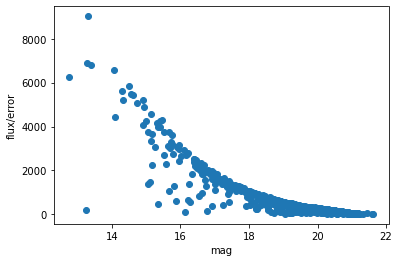

In [5]:
plt.scatter(gaia_zr['Gmag'],gaia_zr['RFG'])
plt.xlabel('mag')
plt.ylabel('flux/error')

Text(0, 0.5, 'flux/error')

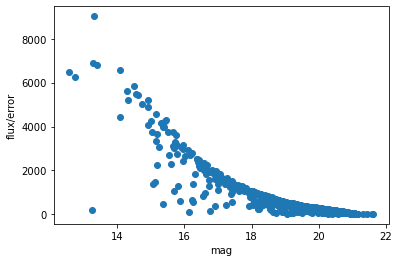

In [6]:
plt.scatter(gaia_zg['Gmag'],gaia_zg['RFG'])
plt.xlabel('mag')
plt.ylabel('flux/error')

In [9]:
t_zr

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64,str37,float64,str15,int32,float64,float64,float64,float64,str1
1,zr,806203100023452,5.0720632,59.3038752,851,427.1630554199219,1.4524961212923433,0.9999958153308316,0.015309100970625877,3.1752911585385783e-17,2800.0,0.997336033066433,0.19455600160117095,0.828718121558811,15.05040168762207,0.015309100970625877,14.99232292175293,15.130514144897461,-0.0011725469958037138,1.2038142681121826,0.48235724946974495,0.14902942755047316,2.824592533146398,1.0,0.05488081763402275,0.0016871191344681735,0.9836370283290529,g1,NonVar,0.6,0.0,1511.901550900002,[CHM2007] LDC 31 J002017.33+5918136,0.734832,GinGroup,1,15.114388,1472.66,0.3951,0.1062,N
1,zr,1809211300007650,5.0720654,59.3038596,77,299.4801025390625,1.1851211036605616,0.9981997509944572,0.011568024754524231,0.11454843350744998,0.10272337615237741,2800.0,0.21220607908278846,0.014182862102960344,15.044246673583984,0.011568024754524231,15.019607543945312,15.088167190551758,-0.0011076524388045073,1.0815422534942627,7.691495349172446,11.43936826330771,16.4795450267754,1.0,0.8676756539226124,0.2525176926349306,0.8319298278786083,g1,DSCT,0.27,1.0,0.10272079145728628,[CHM2007] LDC 31 J002017.33+5918136,0.734832,GinGroup,1,15.114388,1472.66,0.3951,0.1062,N
2,zr,1809211300070217,5.0690426,59.3040475,56,20.568172454833984,1.4475981996385179,0.9386170974691139,0.15365347266197205,0.1074781086890979,0.37890453869539864,2800.0,0.2778420325947693,0.037633445760631774,20.251352310180664,0.15365347266197205,19.95233154296875,20.715749740600586,-0.12701313197612762,1.2117805480957031,0.12220204058816697,0.15784787133740305,0.09753925664793019,1.0,0.7175947795787108,0.9507177794597677,0.3868711012969295,gu,NonVar,0.44,1.0,0.03860415050793573,--,nan,--,1,20.248793,199.839,-0.7083,0.6045,N
2,zr,806203100065936,5.0690334,59.3040661,501,32.86368179321289,1.720545692801813,0.9582426406442783,0.15914002060890198,0.014313439395987624,0.29343072946306986,0.997343815080248,0.08066567509773769,0.003899007689213132,20.25907325744629,0.15914002060890198,19.6058349609375,20.76239013671875,-0.1274305284023285,1.329569697380066,0.008008459690955328,0.00843750045799339,0.039886978110141094,1.0,0.5222407916467862,0.02626604237364416,0.9748122646586905,g1,NonVar,0.69,1.0,0.03133595528004489,--,nan,--,1,20.248793,199.839,-0.7083,0.6045,N
3,zr,806203100057022,5.0755433,59.3020667,716,37.69181442260742,1.571952371493106,0.9992624947012461,0.11341223865747452,0.06381223460712625,0.11947880733901506,0.997336033066433,0.05450309054787811,0.006059245845272846,19.72352409362793,0.11341223865747452,19.399478912353516,20.101001739501953,-0.0998307392001152,1.263882040977478,0.04066865471004858,0.01812575768444976,0.1534866931895394,1.0,0.11074222557864655,0.008343830861197277,0.9495883798098617,g1,NonVar,0.57,1.0,0.2284414330244274,--,nan,--,1,19.72043,317.362,0.4084,0.3136,N
4,zr,806203100065940,5.0739557,59.3015362,37,16.96639633178711,2.6638452457437145,0.12783449129189933,0.2826226055622101,0.000256625330625918,0.18071546460548857,0.9972560997935076,0.727522610000513,0.4713412770901734,21.201833724975586,0.2826226055622101,20.41510009765625,21.721399307250977,-0.16652198135852814,1.6300477981567383,0.15947146803044537,0.12934442394467066,0.18433703530765855,0.0,0.33379363946579277,0.25749922614877563,0.5733481439343764,g1,DSCT,0.46,1.0,0.034914986771452876,--,nan,--,0,0.0,0.0,0.0,0.0,N
3,zr,1809211300054451,5.075586,59.3020625,74,34.38906478881836,1.872425438238

In [18]:
t_zr[t_zr['var']=='P'].show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
0,52,zr,806203100023276,5.0806496,59.3093092,664,48.39557647705078,9.548270702053268,1.3227187319910005e-189,0.3108588755130768,1.7018337280194596e-78,595.2450708466688,0.997336033066433,0.6229683753591274,0.21949631231274336,19.675853729248047,0.3108588755130768,19.17412567138672,20.918895721435547,-0.7161276936531067,3.285275936126709,0.05060821258505381,0.007833020026423389,0.026125014733712922,0.0,0.014227170500624942,0.0517871312497491,0.20132354399945207,g2,LPV_OSARG_AGB,0.33,0.0,566.9630815875007,[HL90] 61,1.854526,HII,1,18.839401,159.932,0.351,0.184,P
1,77,zr,806203100063307,5.0870906,59.2998095,836,344.7351989746094,40.842491010031104,0.0,0.22717958688735962,7.488112388238467e-24,26.55255504914417,0.997336033066433,0.25554257162342087,0.0034232661997002983,18.791976928710938,0.22717958688735962,17.675485610961914,19.1998348236084,-0.8078729510307312,6.599571704864502,0.010941253454579771,0.0022451831278411214,0.04598158685382897,1.0,0.024749755228021697,0.001446042828369909,0.961198797591372,g1,CEPH_Other,0.44,0.0,26.524588612280738,[WWW2005] XA 11,0.264632,X,2,19.001991,118.576,0.0394,0.2003,P
2,90,zr,806203100056957,5.0836327,59.3114535,846,567.4482421875,120.79296419281002,0.0,0.3739984333515167,3.247011689208663e-280,2043.207284960579,0.997336033066433,0.9506730073393318,0.47493011002121566,18.124500274658203,0.3739984333515167,17.195171356201172,18.949966430664062,-2.5609970092773438,11.737095832824707,0.18947997991941207,0.020160519579386485,0.15060952910358819,0.0,0.006788985925998747,0.01068657840378251,0.38484022277800156,g2,LPV_Mira_AGB_C,0.26,0.0,2267.852326350003,LGGS J002020.03+591841.2,0.205743,Em*,2,19.434788,102.102,-0.3582,0.2602,P
3,145,zr,806203100043772,5.0957151,59.2994528,717,66.61664581298828,3.5379984089296954,2.2753838245357322e-18,0.14171883463859558,1.0515294240953812e-12,981.7766691905116,0.997336033066433,0.17591322363193937,0.09890003454859338,19.4619083404541,0.14171883463859558,18.99640655517578,20.149547576904297,-0.18844391405582428,1.9061943292617798,0.014671911593230497,0.003428865224048767,0.0160385433525674,0.0,0.03191100590870233,0.026816135608569547,0.5452531399277134,g2,NonVar,0.35,0.0,1133.9261631750014,LGGS J002022.99+591757.8,0.329861,Em*,1,19.65069,160.035,1.0136,0.3862,P
4,158,zr,806203100057075,5.0953672,59.297784,702,85.88482666015625,6.528562040377028,1.9791103413711206e-94,0.179270938038826,5.255097789862924e-52,595.2450708466688,0.997336033066433,0.4806277327856466,0.1408160323876546,19.39754295349121,0.179270938038826,18.829944610595703,19.830501556396484,-0.3216327726840973,2.6130337715148926,0.04033986549469937,0.01823640263202334,0.044388907661337296,0.0,0.1137638087262609,0.09485607097744764,0.5485841987547181,g1,LPV_SRV_AGB_O,0.39,0.0,647.9578075285723,LGGS J002022.90+591751.8,0.252989,Em*,1,19.25806,233.814,-0.0851,0.2523,P
5,168,zr,806203100060423,5.0989475,59.3023316,603,43.353397369384766,3.6096865088249213,9.805802856611858e-19,0.20166358351707458,5.211841335015464e-23,481.50270086755603,0.997336033066433,0.28793891233976,0.19382587404148513,19.980669021606445,0.20166358351707458,19.334941864013672,20.572986602783203,-0.2577386200428009,1.9497979879379272,0.02288762441783082,0.005203361869715385,0.015654582112170936,0.0,0.030238490340185997,0.06319318525503015,0.31436707892533344,g2,LPV_OSARG_AGB,0.26,0.0,503.96718363333395,[HL90] 92,1.336543,HII,1,19.611233,144.66,-0.2067,0.3311,P
6,208,zr,806203100063224,5.064121,59.3186488,785,57.229671478271484,14.973554136565346,0.0,0.36998096108436584,5.372709522621155e-121,706.5076598069519,0.997336033066433,0.7610530058290755,0.04136356170280423,19.66598129272461,0.36998096108436584,19.04568481

L-S_period: 1.0002392170030603
fit_period: 0.7273687348423777
sin_chi2: 1.76364897
L-S_period: 0.10077406759822505
fit_period: 0.09396139231212855
sin_chi2: 1.30666888
L-S_period: 333.4203659481394
fit_period: 317.5455098616631
sin_chi2: 2.46983936
L-S_period: 0.2130330835622606
fit_period: 0.18859149906374856
sin_chi2: 1.49738489


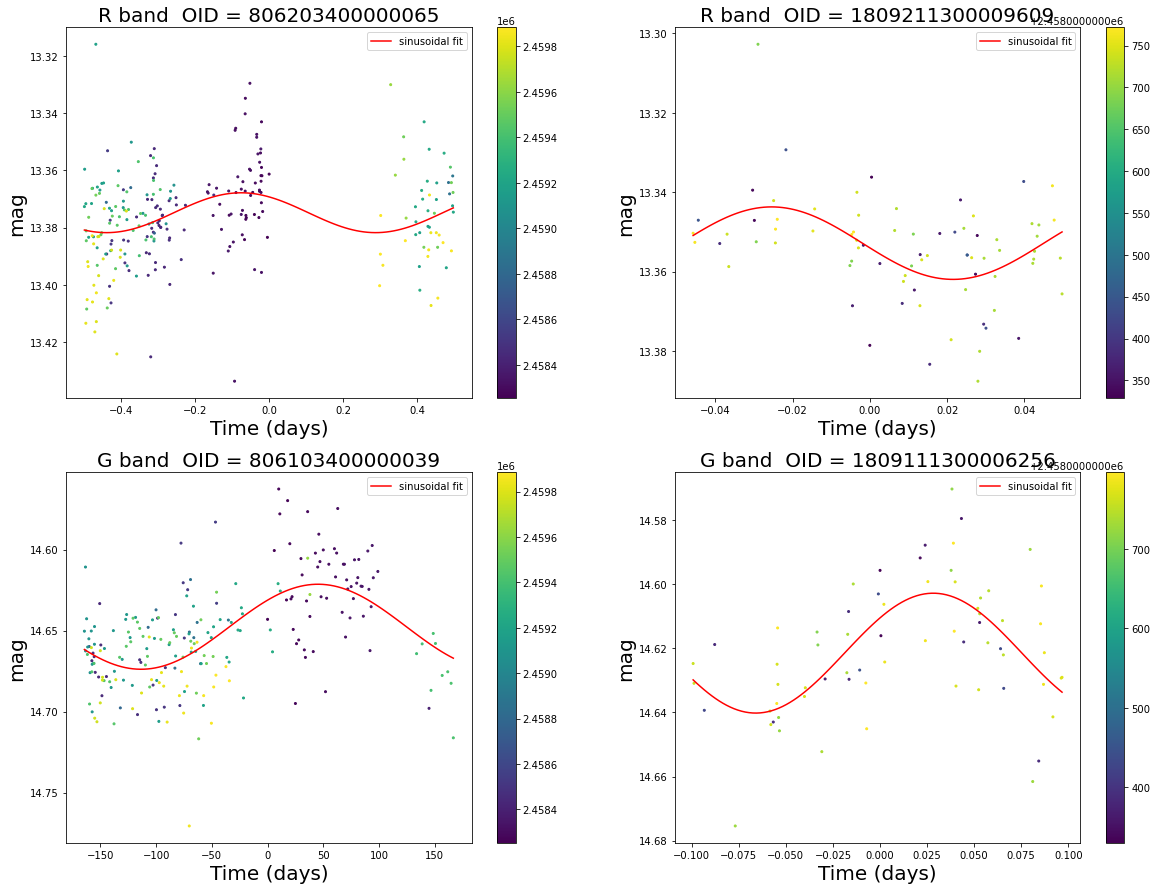

In [40]:
functions.sinfit(1642)

In [17]:
t_zr[t_zr['var']=='V'].show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
0,12,zr,806203100066818,5.069274,59.3074299,167,38.62506866455078,5.4944024701455545,9.217111019517894e-17,0.2700285315513611,0.00021013434860040517,0.4566157532376991,0.9973333841843243,0.29201654576710834,0.008228704730637578,20.4832763671875,0.2700285315513611,19.453529357910156,21.023212432861328,-0.3274482786655426,2.427025079727173,0.026967608701741325,0.016230250088820654,0.07123286836295019,1.0,0.19442554089883513,0.030369462729987973,0.8883335842174575,g1,RRL_ab,0.77,1.0,0.4566344670024419,--,nan,--,0,0.0,0.0,0.0,0.0,V
1,20,zr,1809211300076991,5.0691277,59.3082536,46,85.31249237060547,14.833033808752194,9.821455378235338e-46,0.238337442278862,0.0009484488600492309,0.20114555789648214,2800.0,0.4643514490120347,0.3388473438128968,19.600730895996094,0.238337442278862,18.895540237426758,19.957366943359375,-0.5977720022201538,3.9943113327026367,0.12025828486817411,0.05269243174762823,0.17655820489025872,1.0,0.1072179347508545,0.051324851833480456,0.687506386269991,g1,DSCT,0.59,1.0,0.04605270553638134,--,nan,--,1,20.466309,132.148,1.6057,0.7252,V
2,20,zr,806203100066817,5.0690773,59.308307,353,103.71881103515625,13.06176877588796,5.1662340832829e-156,0.23791329562664032,1.79979578137976e-05,0.12073697967257582,0.9973470410621691,0.17624260089374608,0.0005700225019309988,19.610328674316406,0.23791329562664032,18.595252990722656,20.00849723815918,-0.5374273061752319,3.764411211013794,0.15264288109854532,0.02084012735260599,0.23148564087341364,1.0,0.011111025658078089,0.004876309036507376,0.7018657455808385,g1,DSCT,0.56,1.0,0.1207363352608629,--,nan,--,1,20.466309,132.148,1.6057,0.7252,V
3,25,zr,1809211300076069,5.0695404,59.308852,67,86.57488250732422,8.766948483866713,9.891503717332867e-30,0.18083438277244568,6.419069598524588e-05,382.40917435630683,2800.0,0.4049324330532307,0.9525076567251263,19.47893714904785,0.18083438277244568,18.895540237426758,19.88911247253418,-0.35901835560798645,3.0178394317626953,0.06662596005886386,0.08707685603437394,0.12186184361299764,0.0,0.7299112288103339,0.2661165413063262,0.7779511882378652,g1,DSCT,0.48,1.0,0.041057210231135226,--,nan,--,1,20.63306,105.601,0.088,0.9781,V
4,25,zr,806203100066749,5.0696305,59.3089227,624,162.4963836669922,16.093131543321146,0.0,0.210506409406662,7.105954714418323e-06,1.0027688893986446,0.9973303714334496,0.11249292494696628,0.005477128402830466,19.45784568786621,0.210506409406662,17.984739303588867,19.978656768798828,-0.47452685236930847,4.137101650238037,0.010038801861206986,0.01618997435875815,0.03524402849599354,0.0,0.9476682117988429,0.11726649393188038,0.940214784678697,g1,NonVar,0.57,1.0,0.08922498356213009,--,nan,--,1,20.63306,105.601,0.088,0.9781,V
5,34,zr,1809211300070171,5.0727284,59.3098249,31,81.30490112304688,7.451470886438102,2.3595134061374747e-11,0.1517023891210556,0.11556026631576935,0.1240045534413452,2800.0,0.43705000916041337,0.1948276490633615,19.289358139038086,0.1517023891210556,18.910890579223633,19.555213928222656,-0.28222447633743286,2.735348701477051,0.44073983462560923,0.5540522748460567,0.46764695860749705,1.0,0.6894512650780728,0.6300261912877945,0.5301494257802675,g1,DSCT,0.69,1.0,0.044120282725895896,NVSS J002017+591841,1.176509,Radio,0,0.0,0.0,0.0,0.0,V
6,34,zr,806203100060368,5.0725296,59.3098467,262,80.29171752929688,7.117226100332736,2.2607034617993476e-41,0.17434047162532806,0.008108579964863858,0.17204026613816514,0.997343815080248,0.15900530649983438,0.00012080295156057017,19.31197738647461,0.17434047162532806,18.88072967529297,19.74237823486328,-0.3230542242527008,2.718236207962036,0.019308752196863933,0.009141940373133643,0.07060550749620839,1.0,0.12415968294451318,0.010007429886732089,0.945657262

In [19]:
t_zg[t_zg['var']=='P'].show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
0,73,zg,806103100048650,5.0758587,59.2958026,97,64.1142578125,8.935053528431245,1.364237212874404e-43,0.23146717250347137,1.5286033678611772e-06,1.0323211002809742,0.9972896868175051,0.35458712707540346,0.17918306600135617,20.327228546142578,0.23146717250347137,19.153165817260742,20.794662475585938,-0.3369257152080536,3.0768370628356934,0.009533430482035768,0.01393656832479377,0.05977027922886222,0.0,0.8494752978458127,0.031768959029891186,0.986429830676151,g1,CEPH_Other,0.49,1.0,2.150138196410262,[HL90] 46,1.931646,HII,2,20.611589,89.1981,-2.2708,1.232,P
1,77,zg,806103100029923,5.0869784,59.2997881,258,80.47639465332031,16.358047581022113,8.308402166762659e-291,0.31344184279441833,2.3170100655180286e-16,26.55360081018743,1.0000143393856216,0.29023605619128945,0.005352919590317105,20.02450942993164,0.31344184279441833,18.832887649536133,20.759401321411133,-0.705572783946991,4.285964488983154,0.012970672357106496,0.004716468677232082,0.04254821537149007,1.0,0.07510737992757988,0.007362311539822919,0.9301277856779838,g1,CEPH_Other,0.42,0.0,26.525643273684214,[WWW2005] XA 11,0.385353,X,2,19.001991,118.576,0.0394,0.2003,P
2,90,zg,806103100049624,5.0834336,59.3114529,324,188.7042694091797,29.36702577363452,0.0,0.29480019211769104,3.044761670180407e-168,2043.2292424728973,1.0000143393856216,0.9125489407249586,0.43350509622734634,18.898109436035156,0.29480019211769104,18.297286987304688,19.611181259155273,-1.0131325721740723,5.650538921356201,0.23967239977166246,0.05805681475716322,0.1527728485996977,0.0,0.034221739839404575,0.08173142602727546,0.2834658939107344,g2,LPV_OSARG_AGB,0.31,0.0,1511.9616666,LGGS J002020.03+591841.2,0.158893,Em*,2,19.434788,102.102,-0.3582,0.2602,P
3,443,zg,806103100029740,5.0330754,59.3138586,121,28.574586868286133,3.3070619221753326,6.971346953456639e-06,0.26791107654571533,3.359681295461664e-06,29.544695873850177,0.9973551322251167,0.2801948798759783,0.2318731325804575,21.151514053344727,0.26791107654571533,20.161453247070312,21.6740779876709,-0.17529430985450745,1.8428221940994263,0.010316458679054518,0.006362017515134781,0.030776770835100883,1.0,0.203366265737858,0.02510780192785278,0.9137189280521205,g1,T2CEPH,0.27,1.0,29.58474232302639,--,nan,--,1,19.625738,358.337,0.3256,0.3,P
4,959,zg,806103100020224,5.004683,59.2957142,88,36.86333084106445,4.684628152743749,1.3916365366418321e-11,0.2844848036766052,6.385254250041842e-06,0.9693858486637983,0.9972475558737529,0.3530172255660577,0.07943363226649049,21.140100479125977,0.2844848036766052,19.84897232055664,21.54222869873047,-0.21879763901233673,2.201746702194214,0.00920805259315513,0.005431715300011654,0.017270368757692202,1.0,0.18734195820079003,0.056801398176059115,0.7871738038182378,g1,CEPH_Other,0.55,1.0,0.9693417887075744,--,nan,--,2,19.91913,301.048,0.2937,0.3541,P
5,1219,zg,806103100019623,5.1471037,59.3192505,227,50.598838806152344,3.1444243020941505,6.549911462187277e-08,0.19112929701805115,6.941202255880496e-07,29.447495953900567,0.997381150869086,0.17618709053449363,0.09778859934213133,20.59395980834961,0.19112929701805115,19.435989379882812,21.078689575195312,-0.1532217562198639,1.797919750213623,0.02173485481299379,0.00026880113902417123,0.03757309482655187,1.0,9.34218087796923e-05,3.1292537591598446e-05,0.756364219230733,g1,CEPH_Other,0.19,1.0,29.563396567549706,--,nan,--,1,18.942726,618.349,0.5283,0.1888,P
6,1642,zg,806103400000039,5.125632,59.2614822,193,319.8429260253906,3.8277717316687054,2.0313202423838072e-13,0.03029390051960945,9.879192641170996e-17,333.4203659481394,1.000014139092549,0.3710084864897626,0.061699838152285046,14.649717330932617,0.03029390051960945,14.5626220703125,14.71679973602295,-0.00419855583

In [20]:
t_zg[t_zg['var']=='V'].show_in_notebook()

idx,SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
0,20,zg,1809111300053258,5.0692137,59.3082575,17,32.90401840209961,7.058591943063902,2.0357542686562495e-06,0.28627848625183105,0.00425461062916591,0.45742013831361766,2800.0,0.7925195186482105,0.28002461782951105,20.211742401123047,0.28627848625183105,19.569068908691406,20.56301498413086,-0.45348548889160156,2.713623523712158,0.6575891632530455,0.5175995777195407,0.6551065597372026,0.0,0.31650882318606,0.3186437457643728,0.49807361935085837,gu,DSCT,0.59,1.0,0.17526332505138772,--,nan,--,1,20.466309,132.148,1.6057,0.7252,V
1,25,zg,806103100042687,5.0693889,59.3087403,237,92.99468231201172,7.836505926956435,1.512161804629138e-83,0.2091728299856186,1.3050029596712171e-13,365.20933973392897,1.0000143393856216,0.27259997355979004,0.4319465018424059,20.036285400390625,0.2091728299856186,18.759004592895508,20.42414093017578,-0.3137721121311188,2.870281219482422,0.005032831736797012,0.0007655728812316515,0.030898521657569875,1.0,0.013749444378141296,0.00037407861582017254,0.9856220212643277,g1,CEPH_Other,0.65,1.0,0.9947116227631579,--,nan,--,2,20.63306,105.601,0.088,0.9781,V
2,25,zg,1809111300047902,5.0694621,59.3088523,36,40.49337387084961,5.178225498591696,8.048144074547564e-07,0.22259026765823364,0.00047935979507551194,0.17544479025567672,2800.0,0.5728030200438375,0.04952022327252487,20.041297912597656,0.22259026765823364,19.389726638793945,20.490066528320312,-0.3091849982738495,2.317760705947876,0.06488461442003488,0.021163611004506994,0.059744777164266294,1.0,0.060936121212942895,0.0714271704005417,0.45805178479963216,gu,DSCT,0.73,1.0,0.11622198129980171,--,nan,--,2,20.63306,105.601,0.088,0.9781,V
3,55,zg,806103100036162,5.0724243,59.3110593,337,524.6041259765625,11.53433716011322,3.585358205401398e-226,0.09109293669462204,6.624513205261614e-05,0.9972441069114794,1.0000143393856216,0.09943739652561774,0.904815666787983,17.759519577026367,0.09109293669462204,17.35228729248047,18.282495498657227,-0.11940788477659225,3.39772629737854,0.021082675533131933,0.0009674376856350767,0.058600720395744474,1.0,0.0012778740354683071,0.0001663393556028403,0.8995923437308072,g1,RRL_ab,0.53,1.0,0.4986132790810157,[BGR2000] Br 1,0.179192,HII,2,20.936609,21.5516,nan,nan,V
4,55,zg,1809111300028565,5.07245,59.3110868,66,392.635986328125,14.967355206033764,8.396331195386733e-66,0.09816054254770279,0.001972449838350469,0.22232818693454928,2800.0,0.33767960153347515,0.09093510017475841,17.740047454833984,0.09816054254770279,17.36347198486328,17.94055938720703,-0.16121967136859894,3.8505306243896484,0.379122196310376,0.1487498025445291,0.17974030374835914,1.0,0.0868797174594248,0.34586527658886057,0.1729739946754486,gu,DSCT,0.5,1.0,0.05968903932818899,[BGR2000] Br 1,0.179192,HII,2,20.936609,21.5516,nan,nan,V
5,56,zg,806103100029856,5.0862436,59.3045272,309,61.085147857666016,3.4623099247260845,1.8886564677419793e-14,0.1502600759267807,5.4482071537416684e-30,0.9965867884597146,1.0000143393856216,0.3883192529178018,0.014216191609205953,19.677518844604492,0.1502600759267807,19.24025535583496,20.21525764465332,-0.18144537508487701,1.8833640813827515,0.08045109434852815,0.005376393563223007,0.05891360003595823,0.0,0.0026992241873167178,0.005009378445266943,0.34568562723139695,g2,EB_ESD,0.43,1.0,0.9964597978471003,--,nan,--,1,18.044952,463.443,-0.1818,0.1085,V
6,62,zg,806103100045182,5.0621142,59.2981,260,43.242408752441406,3.151897575172214,7.090268433266282e-09,0.17136166989803314,0.0004929425776710827,0.10066765037466299,1.0000143393856216,0.1115494947844231,0.006906196772473298,20.116044998168945,0.17136166989803314,19.540489196777344,20.555198669433594,-0.18267293274402618,1.8031915426254272,0.04276290089432524,0.04131147802692917,0

In [8]:
gaia1 = QTable.read('1672970823510O-result.fits.gz')
gaia2 = QTable.read('1672939799489O-result.fits.gz')

Text(0, 0.5, 'flux/error')

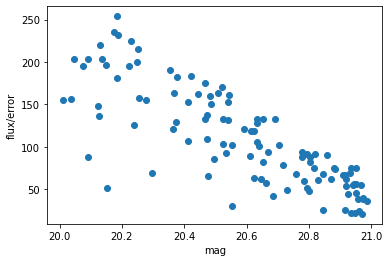

In [9]:
plt.scatter(gaia1['phot_g_mean_mag'],gaia1['phot_g_mean_flux_over_error'])
plt.xlabel('mag')
plt.ylabel('flux/error')

In [11]:
gaia1[(gaia1['phot_g_mean_mag']<20.2)&(gaia1['phot_g_mean_flux_over_error']<100)]

source_id,ra,dec,parallax,pmra,pmdec,ruwe,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,bp_rp,bp_g,g_rp,phot_variable_flag,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,azero_gspphot,ag_gspphot,ebpminrp_gspphot
int64,float64,float64,float64,float64,float64,float32,int32,float64,float32,float32,float32,int32,float64,float32,float32,float32,int32,float64,float32,float32,float32,float32,float32,float32,bytes13,int32,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32
428242947042535424,5.105082104629955,59.30200241857721,--,--,--,--,134,163.8254424382237,3.218139,50.90689,20.151413,0,--,--,--,--,0,--,--,--,--,--,--,--,NOT_AVAILABLE,0,False,False,False,False,False,False,False,--,--,--,--,--,--,--
428243153211336576,5.083579244145138,59.30526999383627,3.0933600675905737,-3.335401007060249,1.0021608375295248,3.0698185,420,173.4003380071733,1.964363,88.27306,20.089743,19,79.43451876605062,9.118501,8.711357,20.588518,21,261.7723404646833,9.319393,28.08899,18.703087,1.8854313,0.49877548,1.3866558,NOT_AVAILABLE,0,False,False,False,False,False,False,False,--,--,--,--,--,--,--


In [65]:
functions.counterpart(5.105082104629955,59.30200241857721,t_zr)

0.761124arcsec


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64,str37,float64,str15,int32,float64,float64,float64,float64,str1
255,zr,806203100052143,5.1049046,59.3018114,768,726.105712890625,24.162722819460555,0.0,0.13452817499637604,0.00015980925805132346,1.0320570038278234,0.997336033066433,0.08159211727001876,0.023363381928109106,17.983001708984375,0.13452817499637604,17.139314651489258,18.532527923583984,-0.35124221444129944,4.948166370391846,0.0031694222126885684,0.00014186082236953483,0.035491512638972864,1.0,0.0012160553774285265,9.773951707980899e-06,0.9975068338387034,g1,EB_ED,0.44,1.0,1.0320147105119468,LGGS J002025.14+591807.0,0.673288,Em*,5,19.525578,160.228,3.4626,0.6468,V


In [66]:
functions.counterpart(5.083579244145138,59.30526999383627,t_zr)

0.158683arcsec


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64,str37,float64,str15,int32,float64,float64,float64,float64,str1
38,zr,1809211300061950,5.083508,59.3052949,60,38.423423767089844,2.060456008126854,0.4114476303151597,0.12166594713926315,0.16883113253642965,0.6888438903168187,2800.0,0.24874767442541657,0.022993975162288457,19.72972297668457,0.12166594713926315,19.42612075805664,20.071788787841797,-0.12656660377979279,1.440281629562378,0.2616311190973077,0.1469586028959372,0.27096412523793106,1.0,0.17106456094631994,0.16024462879671086,0.5178448638560841,g1,DSCT,0.59,1.0,0.0486629591818048,--,nan,--,1,20.089743,88.2731,3.0934,1.3626,N


Text(0, 0.5, 'flux/error')

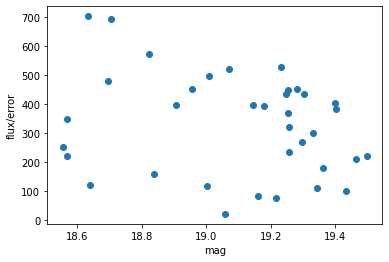

In [10]:
plt.scatter(gaia2['phot_g_mean_mag'],gaia2['phot_g_mean_flux_over_error'])
plt.xlabel('mag')
plt.ylabel('flux/error')

In [17]:
gaia2[(gaia2['phot_g_mean_mag']<19.0)&(gaia2['phot_g_mean_flux_over_error']<200)]

source_id,ra,dec,parallax,pmra,pmdec,ruwe,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,bp_rp,bp_g,g_rp,phot_variable_flag,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,azero_gspphot,ag_gspphot,ebpminrp_gspphot
int64,float64,float64,float64,float64,float64,float32,int32,float64,float32,float32,float32,int32,float64,float32,float32,float32,int32,float64,float32,float32,float32,float32,float32,float32,bytes13,int32,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32
428242843973086080,5.091630344610302,59.290117381670385,0.046079703030503516,-0.26665606571254236,0.005448802871851353,0.99696153,501,658.554817792151,5.385647,122.27962,18.640886,57,147.3690403801974,8.054404,18.296703,19.917526,59,1108.2155484274303,21.95895,50.4676,17.136335,2.7811909,1.2766399,1.5045509,VARIABLE,0,False,False,False,True,False,False,False,--,--,--,--,--,--,--
428243148910399360,5.080595648183666,59.30929539880679,0.3510477567021877,-0.02635986848746051,-0.1728265011956533,0.97436297,471,548.5124526060583,3.429659,159.93208,18.839401,44,54.63558558588393,5.167697,10.572521,20.994854,52,690.5103286118593,13.69915,50.405342,17.64997,3.3448849,2.1554527,1.1894321,VARIABLE,0,False,False,False,True,False,True,False,3926.2756,4.6776,0.0138,501.6054,3.4845,2.2566,1.3157


In [67]:
functions.counterpart(5.091630344610302,59.290117381670385,t_zr)

0.0623538arcsec


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64,str37,float64,str15,int32,float64,float64,float64,float64,str1
265,zr,1809211300054610,5.0916639,59.2901199,74,206.76882934570312,39.5988316539588,7.38178162628605e-254,0.2967183291912079,5.874071083694701e-25,251.90706206454647,2800.0,0.8340143824925549,0.21932614119590574,18.75215721130371,0.2967183291912079,18.283201217651367,19.337295532226562,-1.3767894506454468,6.630406379699707,0.37298737129650444,0.07891517784182941,0.3546725541628099,0.0,0.026275949809311472,0.02899347588061585,0.4743761155354542,g2,LPV_Mira_AGB_C,0.3,1.0,1328.6920833000113,2MASS J00202199+5917244,0.046452,Star,2,18.640886,122.28,0.0461,0.1623,N


In [68]:
functions.counterpart(5.080595648183666,59.30929539880679,t_zr)

0.0776307arcsec


SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64,str37,float64,str15,int32,float64,float64,float64,float64,str1
52,zr,1809211300054348,5.0806374,59.3092921,70,54.861793518066406,3.8287349694500223,7.479393901880701e-06,0.1666656732559204,1.9070708062533334e-05,462.22886833491833,2800.0,0.4143551402254435,0.8929084671484715,19.547266006469727,0.1666656732559204,19.179689407348633,20.374217987060547,-0.2487855702638626,1.9824135303497314,0.023752797415915242,0.03586219985223847,0.04073117478282561,1.0,0.8833477322406814,0.38542511478098085,0.7531769233421609,g1,LPV_SRV_AGB_O,0.56,1.0,221.44868054999824,[HL90] 61,1.854526,HII,1,18.839401,159.932,0.351,0.184,N


In [64]:
t_zr=QTable.read('t_zr_0109.ecsv')
t_zg=QTable.read('t_zg_0109.ecsv')

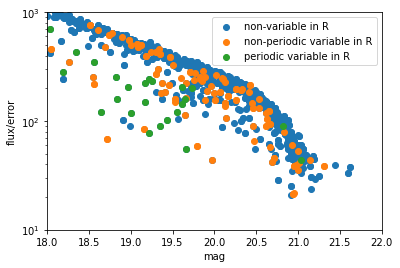

In [27]:
t=t_zr[t_zr['Gmag']!=0]
t1=t[t['var']=='N']
t2=t[t['var']=='V']
t3=t[t['var']=='P']
plt.scatter(t1['Gmag'],t1['RFG'],label='non-variable in R')
plt.scatter(t2['Gmag'],t2['RFG'],label='non-periodic variable in R')
plt.scatter(t3['Gmag'],t3['RFG'],label='periodic variable in R')
plt.xlabel('mag')
plt.ylabel('flux/error')
plt.yscale('log')
plt.xlim(18,22)
plt.ylim(10,1e3)
plt.legend()

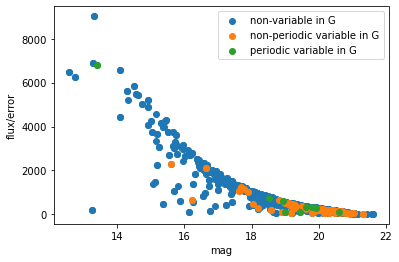

In [84]:
t=t_zg[t_zg['Gmag']!=0]
t1=t[t['var']=='N']
t2=t[t['var']=='V']
t3=t[t['var']=='P']
plt.scatter(t1['Gmag'],t1['RFG'],label='non-variable in G')
plt.scatter(t2['Gmag'],t2['RFG'],label='non-periodic variable in G')
plt.scatter(t3['Gmag'],t3['RFG'],label='periodic variable in G')
plt.xlabel('mag')
plt.ylabel('flux/error')
plt.legend()

In [80]:
t[(t['RFG']<1000)&(t['Gmag']<14)]

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,rmse,LNP_SIG,period,period_c,power,power_c,mean,std,min,max,sigma_mean,sigma_std,gaussian1_err,gaussian2_err,gumbel_err,g2_flag,Pg1g2,Pgug2,Pg1gu,shape,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period,identifier,dist,type,Gaia_count,Gmag,RFG,Plx,e_Plx,var
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str14,float64,float64,float64,str37,float64,str15,int32,float64,float64,float64,float64,str1
1389,zr,1809211300007710,4.9838492,59.3010354,71,330.35369873046875,1.3523361017151811,0.9827993151702921,0.01137793343514204,0.002150344471986594,0.17026946545644697,2800.0,0.31714035339556274,0.0607966351353408,13.05174446105957,0.01137793343514204,13.020025253295898,13.084173202514648,-0.00011154463572893292,1.1546814441680908,21.884391884322067,3.16615520169699,3.334062152387229,1.0,0.01245624567304171,0.4389475612843894,0.011946823094608372,gu,EB_ED,0.34,1.0,0.20520361969111942,--,nan,--,1,13.255477,209.016,-0.2821,0.6508,N
1389,zr,806203100023513,4.9838358,59.3010536,837,382.0777893066406,1.6108735335853692,0.9988275602924929,0.015636194497346878,1.5628165686443559e-22,2800.0,0.997336033066433,0.24110286538438735,0.8335447187223597,13.051304817199707,0.015636194497346878,12.988446235656738,13.104721069335938,0.00021213955187704414,1.2677321434020996,3.5257441868811523,0.06545231456682926,5.458884747960822,1.0,0.00021024811993597403,8.781588388395711e-05,0.7108813164921761,g1,NonVar,0.91,0.0,2267.852326350003,--,nan,--,1,13.255477,209.016,-0.2821,0.6508,N


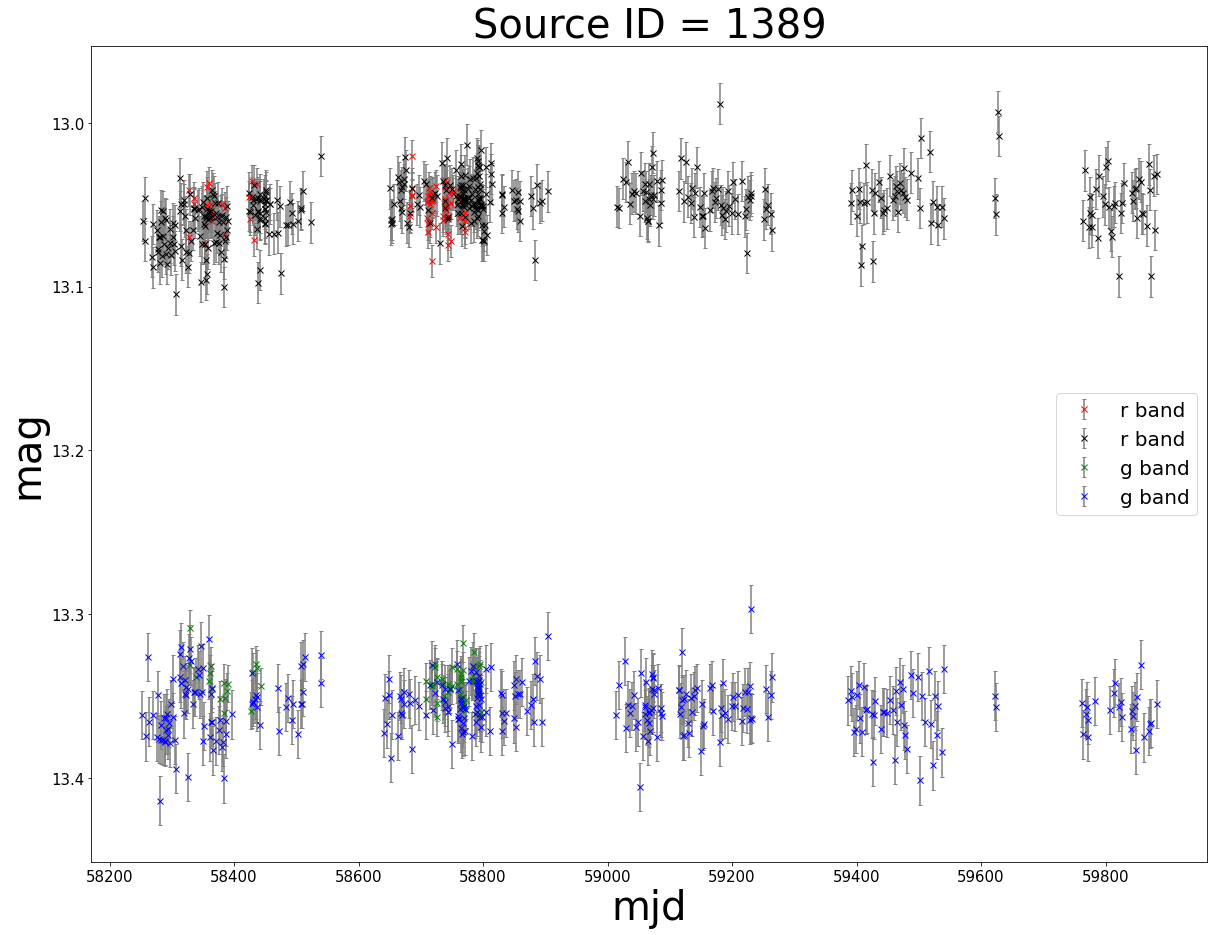

In [82]:
functions.draw_lightcurve(1389)